In [5]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators/shabanipy')
sys.path.append('/Users/billystrickland/Documents/code/resonators/shabanipy/shabanipy/resonators/billys_code/utils')
import matplotlib.pyplot as plt
from shabanipy.labber import LabberData
import numpy as np

from scipy.optimize import curve_fit

import qubit_functions as qf
import resonator_functions as rf

root = '/Users/billystrickland/Library/CloudStorage/dStorage/GoogleDrive-wms269@nyu.edu/.shortcut-targets-by-id/1p4A2foj_vBr4k6wrGEIpURdVkG-qAFgb/nyu-quantum-engineering-lab/labber/data-backups/qubitfridge/Data'

In [2]:
def import_data(channels, FILES):
    """
    This function imports I/Q data from Labber data files and optionally the drive data.
    
    Parameters:
    channels : list
        A list of strings representing the channels to be read. If there are 3 channels,
        the third one is assumed to be the drive channel.
    FILES : list
        A list of file paths for Labber data files. The function will read from the first 3 files in the list.
    
    Returns:
    I : numpy.ndarray
        The in-phase data extracted from the first channel.
    Q : numpy.ndarray
        The quadrature data extracted from the second channel.
    drive : numpy.ndarray (optional)
        The drive data extracted from the third channel (if available).
    """
    
    # Unpack the channels based on the length of the 'channels' list
    if len(channels) > 2:
        I_CH, Q_CH, D_CH = channels  # If 3 channels are provided, assign each to I, Q, and D (drive)
    if len(channels) == 2:
        I_CH, Q_CH = channels  # If only 2 channels are provided, assign I and Q channels only
    
    # Iterate over the first 3 files in the FILES list (assuming there are at least 3 files)
    for i, FILE in enumerate(FILES[:3]):
        # Open the Labber data file using the LabberData class (this is assumed to be a custom class for Labber files)
        with LabberData(FILE) as f:
            # Extract the data for the I (in-phase) channel
            I = f.get_data(I_CH)
            # Extract the data for the Q (quadrature) channel
            Q = f.get_data(Q_CH)
            
            # If a drive channel was provided, extract that data as well
            if len(channels) > 2:
                drive = f.get_data(D_CH)
            
            # Return the I and Q data, and optionally the drive data (only if the drive channel is provided)
            return I, Q, drive


In [3]:
### T1 plotting and fitting

# Define the date and sample information
year = '2025'  # Year of the experiment
month = '04'   # Month of the experiment
day = '04'     # Day of the experiment

# Define the sample name and file number for data retrieval
sample = 'CandleQubits-WMSAB-CD06'  # The name of the sample being measured
file_num = 'rabi-018'  # File number for the data (specific to the experiment)

# Construct the path to the data file (HDF5 format)
FILES = [root+'/'+year+'/'+month+'/Data_'+month+day+'/'+sample+'-'+file_num+'.hdf5']
# FILES is a list that contains the full path to the data file. You would need to define the `root` variable earlier in the script.

################################## CHANGE HERE #####################################################
# Define the channels of interest (I, Q, and drive) to import from the file
channels = [
    'Digitizer ShabLab - Ch3 - Signal',  # I (In-phase) channel
    'Digitizer ShabLab - Ch4 - Signal',  # Q (Quadrature) channel
    'MQPG - Readout delay'               # Drive signal or readout delay (if present)
]

# Import the data using the import_data function defined earlier
I, Q, drive = import_data(channels, FILES)
# I and Q are the in-phase and quadrature data arrays, respectively, and 'drive' is the drive signal data

# Define the path where the processed or fit results will be saved
savepath = '/Users/billystrickland/Documents/code/resonators/data/'+sample+'/'
# This will be the directory where you can save your T1 fitting results, plots, etc.


T1, A, b: [6.39983715e-05 1.95375885e-03 1.01428721e-04]


Text(0.4, 0.85, '$T_1$ = 6.400e-05$\\pm$ 7.413e-06 s')

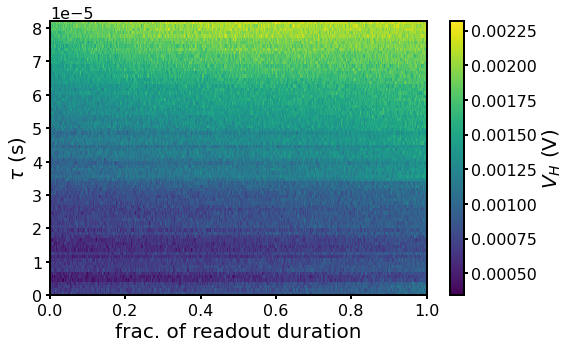

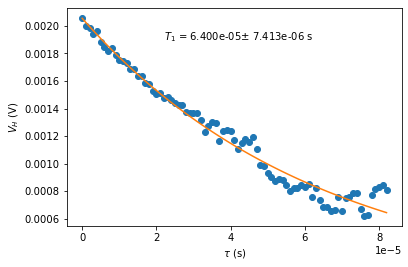

In [4]:
### T1 Fitting and Plotting (without plotting raw data)

# Extract the 'width' of the drive signal corresponding to the duration of the readout
width = drive[0:len(I)]
# The 'width' variable corresponds to the time duration of each readout measurement. It is assumed to be the same length as the in-phase data (I).

# Create a 2D plot (Rabi plot) using a predefined function 'plot_rabi_2d' from the qf module
# This plot shows the relationship between the fraction of readout duration and time, with voltage (V_H) as the color scale
qf.plot_rabi_2d(np.array(I[0:-1]),  # I is the in-phase signal (excluding the last point)
                xlabel=r'frac. of readout duration',  # Label for the x-axis
                ylabel=r'$\tau$ (s)',  # Label for the y-axis (time)
                zlabel='$V_H$ (V)',  # Label for the z-axis (measured voltage)
                extent=[0, 1, width[0], width[-1]]  # Define the limits of the plot
               )

# Integrate over readout duration (calculating the average I signal for each measurement)
I_avg = []
I_avg = [np.mean(x) for x in I]  # Average I signal over all time points in the duration

# Fit the T1 relaxation model (exponential decay) to the averaged I signal using curve fitting
# The `exp_decay` function models the decay and is likely defined in the 'qf' module
popt, pcov = curve_fit(qf.exp_decay, width, I_avg,  # Fit the exponential decay to the data
                       bounds=[[0, -np.inf, -np.inf], [100e-6, np.inf, np.inf]],  # Set bounds for parameters
                       maxfev=500000000)  # Increase the number of function evaluations if needed for convergence

a = popt  # `a` stores the fitted parameters (T1, A, b)
perr = np.sqrt(np.diag(pcov))  # Calculate the standard errors of the fitted parameters

# Print the fitted parameters (T1, A, and b) - these represent the relaxation time, amplitude, and offset of the decay
print('T1, A, b:', a)

# Plot the fitted results

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Determine the sign for the plot based on the direction of decay (whether the signal is decaying or growing)
if I_avg[0] < I_avg[-1]:
    sign = -1  # If the first value is less than the last, assume the signal decays
else:
    sign = 1   # Otherwise, assume the signal grows

# Plot the averaged data points (I_avg) vs time, using markers for each point
plt.plot(width, sign*np.array(I_avg), marker='o', linestyle='None')  # The raw averaged data (no lines)
# Plot the exponential decay fit using the fitted parameters (a)
plt.plot(width, sign*qf.exp_decay(width, *a))  # The fitted exponential decay curve

# Label the axes
plt.ylabel('$V_H$ (V)')  # Voltage on the y-axis
plt.xlabel(r'$\tau$ (s)')  # Time (tau) on the x-axis

# Annotate the plot with the fitted T1 value and its uncertainty
ax.annotate(f'$T_1$ = {a[0]:.3e}$\pm$ {perr[0]:.3e} s',  # Format T1 and its error
            xy=(.4, .85),  # Position of the annotation on the plot
            xycoords='figure fraction')  # Use relative coordinates for placement within the figure


In [15]:
### T2 Ramsey: 2d plot

# Import data
file_num = '065'
day = '11'
FILES = [root+'/'+year+'/'+month+'/Data_'+month+day+'/'+sample+'-'+file_num+'.hdf5']

# Specify the channels to import (I, Q, pulse spacing, and drive frequency)
channels = ['Digitizer ShabLab - Ch3 - Signal',
            'Digitizer ShabLab - Ch4 - Signal',
            'MQPG - Pulse spacing',
            'SC3 - Drive - Frequency']

# Load data from the specified files
for i, FILE in enumerate(FILES[:3]):
    with LabberData(FILE) as f:
        # Retrieve the data for each channel
        data = [f.get_data(channel) for channel in channels]

# Assign the data to variables for I, Q, pulse spacing, and drive frequency
I, Q, width, drive = data


(121, 121, 100)


(<Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='$\\tau_\\mathrm{Ramsey}$ (s)', ylabel='$f_\\mathrm{drive}$ (GHz)'>)

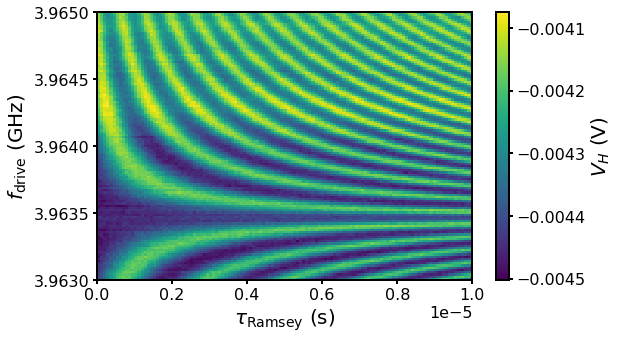

In [16]:
# Extract unique values for drive frequency and pulse spacing
drive = np.unique(drive)
width = np.unique(width)

# Calculate the average of the in-phase signal (I) across the last axis
I_avg = np.mean(I[:, :, :], axis=-1)

# Generate the 2D Rabi plot (Ramsey)
qf.plot_rabi_2d(np.array(I_avg[::-1]), 
                xlabel=r'$\tau_\mathrm{Ramsey}$ (s)',  # Label for the x-axis (pulse spacing)
                ylabel=r'$f_\mathrm{drive}$ (GHz)',  # Label for the y-axis (drive frequency)
                zlabel='$V_H$ (V)',  # Label for the z-axis (measured voltage)
                extent=[width[0], width[-1], drive[0]*1e-9, drive[-1]*1e-9]  # Limits for plot
               )


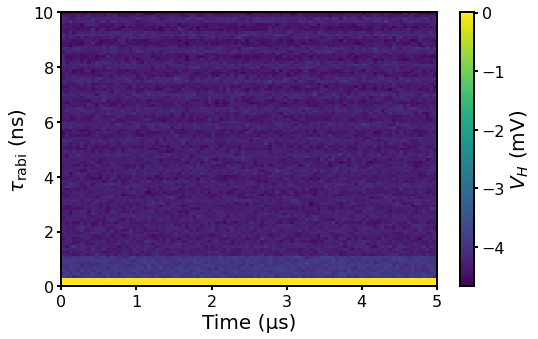

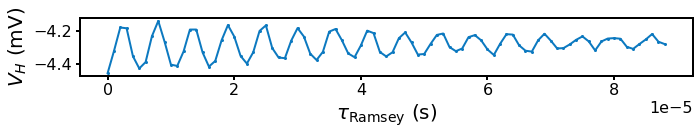

In [28]:
### T2 Ramsey: fitting a linecut

# Import data
file_num = '065'
day = '12'
FILES = [root+'/'+year+'/'+month+'/Data_'+month+day+'/'+sample+'-'+file_num+'.hdf5']

# Specify the channels to import
channels = ['Digitizer ShabLab - Ch3 - Signal',
            'Digitizer ShabLab - Ch4 - Signal',
            'MQPG - Pulse spacing']

# Load the data from the specified files
I, Q, drive = import_data(channels, FILES)

# Restrict the width (pulse spacing) to the first 89 points
width = drive[:89]

# Plot the 2D Rabi plot (Ramsey)
qf.plot_rabi_2d(np.array(I) * 1e3,  # Convert signal to mV for better readability
                xlabel=r'Time (µs)',  # Label for the x-axis (time)
                ylabel=r'$\tau_\mathrm{rabi}$ (ns)',  # Label for the y-axis (Ramsey time)
                zlabel='$V_H$ (mV)',  # Label for the z-axis (measured voltage)
                extent=[0, 5, 0, 10]  # Define the plot limits
               )

# Integrate over the readout duration to calculate the average I value
I_avg = [np.mean(x) for x in I[:89]]  # Calculate the average for the first 89 points

# Plot the averaged data
fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size for better visibility
plt.plot(width, np.array(I_avg) * 1e3, marker='o', markersize=2)  # Plot with markers and convert to mV
plt.ylabel('$V_H$ (mV)')  # Y-axis label (Voltage)
plt.xlabel(r'$\tau_\mathrm{Ramsey}$ (s)')  # X-axis label (Ramsey time)
plt.tight_layout()  # Ensure that the plot elements fit within the figure area


A, T, freq, b, p, m =  [ 1.62465636e-04  5.78375720e-05  1.80119682e+05 -4.28135847e-03
  1.82617836e+02]


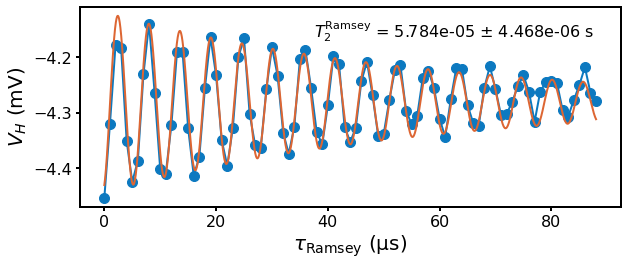

In [29]:
def decaying_sin(t, A, T, freq, b, p):
    # Decaying sine function to fit the data
    return -A*np.exp(-t/T)*np.cos(freq*2*np.pi*t + p) + b

# Define bounds for the fitting parameters
bounds = [[1e-4, 40e-6, 0.1e6, -5e-3, 0],  # Lower bounds for A, T, frequency, b, and phase
          [1e-2, 100e-6, 0.3e6, -4e-3, 360]]  # Upper bounds for A, T, frequency, b, and phase

# Signal data to fit
signal = np.array(I_avg)

# High resolution width for plotting the fitted function smoothly
width_hr = np.linspace(width[0], width[-1], 100000)

# Plotting with customized matplotlib settings
with plt.rc_context(jy_mpl_rc):
    # Create the plot
    fig, ax = rf.make_plot_pre(r'$\tau_\mathrm{Ramsey}$ (µs)', '$V_H$ (mV)', figsize=(9, 4))

    # Fit the decaying sine function to the data
    a, pcov = curve_fit(decaying_sin, width, signal, bounds=bounds, maxfev=500000000)

    # Print fitted parameters: A, T, frequency, b, and phase
    print('A, T, freq, b, p, m = ', a)

    # Calculate the parameter uncertainties
    perr = np.sqrt(np.diag(pcov))

    # Plot the raw data and the fitted curve
    plt.plot(width * 1e6, signal * 1e3, marker='o')  # Plot signal (convert units to mV)
    plt.plot(width_hr * 1e6, decaying_sin(width_hr, *a) * 1e3)  # Plot fitted curve (convert units to mV)

    # Annotate the plot with T2 Ramsey and its uncertainty
    ax.annotate(f'$T_2^{{\mathrm{{Ramsey}}}}$ = {a[1]:.3e} $\\pm$ {perr[1]:.3e} s',
                xy=(0.5, 0.86),  # Position of the annotation
                xycoords='figure fraction')

    # Adjust layout to avoid overlap of plot elements
    fig.tight_layout()

    # Save the plot as a PDF file
    plt.savefig('ramsey_' + file_num + '.pdf', format='pdf')
